# Setup

In [2]:
!/home/ec2-user/anaconda3/envs/tensorflow_p36/bin/python -m pip install --upgrade pip

In [3]:
!pip install -q tensorflow-text

In [4]:
!pip install -q tf-models-official

In [8]:
!pip install numpy requests nlpaug

     |████████████████████████████████| 394 kB 5.9 MB/s eta 0:00:01


In [16]:
!pip install torch==1.6.0 transformers==4.0.0

     |█████████████▊                  | 320.2 MB 88.7 MB/s eta 0:00:054  |▊                               | 16.0 MB 6.4 MB/s eta 0:01:54

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |███████████████████████████▎    | 638.5 MB 155.2 MB/s eta 0:00:01

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |███████████████████████████████▊| 742.2 MB 125.9 MB/s eta 0:00:01

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |████████████████████████████████| 748.8 MB 5.8 kB/s 
     |████████████████████████████████| 1.4 MB 108.2 MB/s eta 0:00:01
     |████████████████████████████████| 2.9 MB 85.4 MB/s eta 0:00:01
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.10.1
    Uninstalling tokenizers-0.10.1:
      Successfully uninstalled tokenizers-0.10.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.3.3
    Uninstalling transformers-4.3.3:
      Successfully uninstalled transformers-4.3.3
  Attempting uninstall: torch
    Found existing installation: torch 1.8.0
    Uninstalling torch-1.8.0:
      Successfully uninstalled torch-1.8.0


In [17]:
!pip install torch==1.6.0 fairseq==0.9.0 sacremoses==0.0.43 fastBPE==0.1.0

     |████████████████████████████████| 306 kB 10.2 MB/s eta 0:00:01
  Created wheel for fairseq: filename=fairseq-0.9.0-cp36-cp36m-linux_x86_64.whl size=693392 sha256=4a28c6e49a050a23add393d9b3d2b80a40f3ef75059e5725c35face513806ac3
  Stored in directory: /home/ec2-user/.cache/pip/wheels/fb/85/9b/286072121774d5b8b0253ab66271b558069189cbe795bc6084
Successfully built fairseq
  Attempting uninstall: fairseq
    Found existing installation: fairseq 0.10.2
    Uninstalling fairseq-0.10.2:
      Successfully uninstalled fairseq-0.10.2


In [18]:
!pip install nltk==3.4.5

     |████████████████████████████████| 1.5 MB 8.4 MB/s eta 0:00:01
  Created wheel for nltk: filename=nltk-3.4.5-py3-none-any.whl size=1449907 sha256=10d71c91cdf92c878e93dc440d9b527ae29a10defb85d78f70bcd53ff04fec93
  Stored in directory: /home/ec2-user/.cache/pip/wheels/e3/c9/b0/ed26a73ef75a53145820825afa8e2d2c9b30fe9f6c10cd3202
Successfully built nltk
  Attempting uninstall: nltk
    Found existing installation: nltk 3.4.4
    Uninstalling nltk-3.4.4:
      Successfully uninstalled nltk-3.4.4


In [61]:
from nlpaug.util.file.download import DownloadUtil
DownloadUtil.download_word2vec(dest_dir='.') # Download word2vec model
DownloadUtil.download_glove(model_name='glove.6B', dest_dir='.') # Download GloVe model
DownloadUtil.download_fasttext(model_name='wiki-news-300d-1M', dest_dir='.') # Download fasttext model

# Import Package

In [19]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optmizer

import matplotlib.pyplot as plt
from tqdm import tqdm


import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as nafc
import nlpaug.flow as naf
from nlpaug.util import Action
tf.get_logger().setLevel('ERROR')

# Data Streaming

In [10]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

train_dir = os.path.join(dataset_dir, 'train')

# remove unused folders to make it easier to load the data
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [20]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
batch_size = 32
seed = 42

In [12]:
from os import listdir
from os.path import isfile, join
training_pos = [f for f in listdir("aclImdb/train/pos") if isfile(join("aclImdb/train/pos", f))]

In [ ]:
from os import listdir
from os.path import isfile, join
training_neg = [f for f in listdir("aclImdb/train/neg") if isfile(join("aclImdb/train/neg", f))]

In [14]:
flow = naf.Sometimes([nas.AbstSummAug(model_path='t5-base', num_beam=3), 
                      naw.ContextualWordEmbsAug(model_path='bert-base-uncased', action="insert"),
                      nac.RandomCharAug(action="substitute"),
                      nac.KeyboardAug(),
                      nac.OcrAug()])

In [ ]:
for f in tqdm(training_pos):
    file = join("aclImdb/train/pos", f)
    cur_str = open(file, 'r').read()
    augmented_str = flow.augment(cur_str, n=1)
    new_txt = "aclImdb/train/pos/" + "aug_" + f
    text_file = open(new_txt, "w")
    text_file.write(augmented_str)
    text_file.close()

 90%|█████████ | 11289/12500 [3:49:33<35:29,  1.76s/it]  

In [ ]:
for f in tqdm(training_neg):
    file = join("aclImdb/train/neg", f)
    cur_str = open(file, 'r').read()
    augmented_str = flow.augment(cur_str, n=1)
    new_txt = "aclImdb/train/neg/" + "aug_" + f
    text_file = open(new_txt, "w")
    text_file.write(augmented_str)
    text_file.close()

In [25]:
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 50000 files belonging to 2 classes.
Using 40000 files for training.
Found 50000 files belonging to 2 classes.
Using 10000 files for validation.
Found 25000 files belonging to 2 classes.


In [26]:
for text_batch, label_batch in train_ds.take(1):
    for i in range(3):
        print(f'Review: {text_batch.numpy()[i]}')
        label = label_batch.numpy()[i]
        print(f'Label : {label} ({class_names[label]})')

Review: b"ThFre was a ressonwboy good looking girl starring the fi/m (Zoe <clelPan) but rven her looks couldn ' t stop me fr)m voting it the lowest possib:4 - one. <br /> <br /> The plot is bad and irrational. <br /> <br /> What mord can I say. The Jovie wucks."
Label : 0 (neg)
Review: b"the movie was by far one of the worst I've ever seen. the actors, script & dialog, directing, editing, etc. were God-awful. i didn't fall asleep during the movie, but even though it was an overly simple plot, i found myself getting lost in the plot holes."
Label : 0 (neg)
Review: b'This movie might not put the Catholic church in the best light but it is telling a story based on true events. Unfortunately not everything in life, including religion, are all nice and rosy. Sometimes people and groups do things that at the time seem like the right thing but in retrospective do not look as great as they once did. "A Love Divided" tells the story of a family, yes it does incorporate religion, but really the 

# Load  Pretrain model

In [27]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/2',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/2',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/2',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2


In [28]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

INFO:absl:Using /tmp/tfhub_modules to cache modules.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2'.
INFO:absl:Downloaded https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2, Total size: 1.96MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2'.


In [29]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_type_ids', 'input_word_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [30]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'.
INFO:absl:Downloaded https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1, Total size: 115.55MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'.


In [20]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.76262915  0.99280983 -0.18611857  0.3667384   0.15233715  0.6550451
  0.9681154  -0.948627    0.00216166 -0.9877732   0.06842688 -0.9763059 ]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.28946406  0.34321284  0.33231527 ...  0.21300796  0.7102072
  -0.05771175]
 [-0.2874205   0.31981015 -0.23018587 ...  0.5845504  -0.21329752
   0.72692037]
 [-0.66157055  0.68876845 -0.8743293  ...  0.1087724  -0.26173186
   0.47855398]
 ...
 [-0.22561164 -0.28925577 -0.07064409 ...  0.47565955  0.8327713
   0.40025365]
 [-0.29824203 -0.2747312  -0.05450513 ...  0.4884973   1.0955358
   0.18163405]
 [-0.44378182  0.00930732  0.07223705 ...  0.17290123  1.1833236
   0.07897992]]


In [31]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [33]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.51284087]], shape=(1, 1), dtype=float32)


In [34]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [35]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


In [36]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [37]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5
1250/1250 [==============================] - 2033s 2s/step - loss: 0.5732 - binary_accuracy: 0.6575 - val_loss: 0.3600 - val_binary_accuracy: 0.8400
Epoch 2/5
1250/1250 [==============================] - 2022s 2s/step - loss: 0.3263 - binary_accuracy: 0.8555 - val_loss: 0.3838 - val_binary_accuracy: 0.8652
Epoch 3/5
1250/1250 [==============================] - 2032s 2s/step - loss: 0.2232 - binary_accuracy: 0.9088 - val_loss: 0.3709 - val_binary_accuracy: 0.8851
Epoch 4/5
1250/1250 [==============================] - 2018s 2s/step - loss: 0.1603 - binary_accuracy: 0.9397 - val_loss: 0.4489 - val_binary_accuracy: 0.8847
Epoch 5/5
1250/1250 [==============================] - 2005s 2s/step - loss: 0.1156 - binary_accuracy: 0.9601 - val_loss: 0.4118 - val_binary_accuracy: 0.8948


In [38]:
classifier_model.evaluate(test_ds)

782/782 [==============================] - 289s 369ms/step - loss: 0.6076 - binary_accuracy: 0.8588


[0.6076233386993408, 0.8587999939918518]

# Performance Plot

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


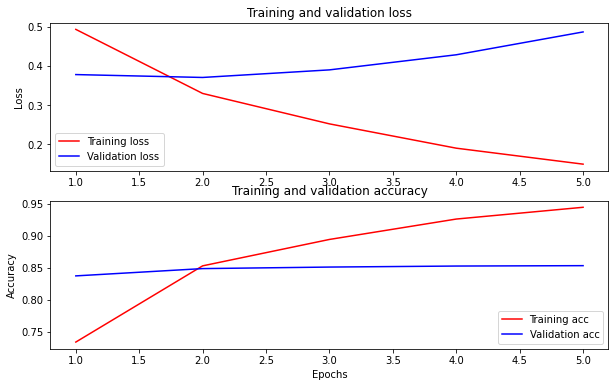

In [31]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [32]:
dataset_name = 'imdb'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

# Inference

In [34]:
reloaded_model = tf.saved_model.load(saved_model_path)

In [ ]:
reloaded_model.evaluate(test_ds)

In [35]:
def print_my_examples(inputs, results):
    result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
    print(*result_for_printing, sep='\n')
    print()


examples = [
    'this is such an amazing movie!',  # this is the same sentence tried earlier
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...'
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

Results from the saved model:
input: this is such an amazing movie! : score: 0.999408
input: The movie was great!           : score: 0.997257
input: The movie was meh.             : score: 0.952110
input: The movie was okish.           : score: 0.019062
input: The movie was terrible...      : score: 0.001034

Results from the model in memory:
input: this is such an amazing movie! : score: 0.999408
input: The movie was great!           : score: 0.997257
input: The movie was meh.             : score: 0.952110
input: The movie was okish.           : score: 0.019062
input: The movie was terrible...      : score: 0.001034



In [36]:
serving_results = reloaded_model \
            .signatures['serving_default'](tf.constant(examples))

serving_results = tf.sigmoid(serving_results['classifier'])

print_my_examples(examples, serving_results)

input: this is such an amazing movie! : score: 0.999408
input: The movie was great!           : score: 0.997257
input: The movie was meh.             : score: 0.952110
input: The movie was okish.           : score: 0.019062
input: The movie was terrible...      : score: 0.001034

